# TTV Fitting in Julia

In [1]:
# Load path to ExoJulia and current directory
push!(LOAD_PATH,"../../../ExoJulia/")
push!(LOAD_PATH,".")

4-element Array{ByteString,1}:
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "../../../ExoJulia/"                                                                
 "."                                                                                 

In [2]:
# Load packages
using ExoJulia
using Optim
using LsqFit

In [3]:
# Load PyPlot for plotting (slow)
using PyPlot

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Read-in TTV data

In [4]:
ttv1_data = readdlm("../ttv_planet1.txt");
ttv2_data = readdlm("../ttv_planet2.txt");

In [5]:
# Reshape into 1d arrays
time1 = reshape(ttv1_data, length(ttv1_data));
time2 = reshape(ttv2_data, length(ttv2_data));

In [6]:
# Compute grid of delta-times (between transits)
dt1 = time1[2:end] - time1[1:end-1];
dt2 = time2[2:end] - time2[1:end-1];

# Find mean delta-time for each planet
mdt1 = mean(dt1);
mdt2 = mean(dt2);

# This is the mean period!
bestP1 = mdt1;
bestP2 = mdt2;

# Estimate standard deviation of mean time
stdt1 = std(dt1);
stdt2 = std(dt2);

print("Inner planet period: ", mdt1, " +/- ", stdt1, "\n")
print("Outer planet period: ", mdt2, " +/- ", stdt2)

Inner planet period: 224.70076641863517 +/- 0.0022854502193227965
Outer planet period: 365.25630708152175 +/- 0.002178896306975526

**Hmm... these periods are quite familiar ;) The inner planet has the orbital period of Venus, and the outer planet has the orbital period of Earth!**

In [193]:
function period_from_times(time::Array{Float64, 1})
    """
    This function computes the mean period from an array of transit times.
    """

    # Delta t between transits 
    dt = time[2:end] - time[1:end-1];
    
    # Mean time between transits --> Period!
    mdt = mean(dt);
    
    # Standard deviation of time between transits 
    # --> on order of TTV
    stdt = std(dt);

    #print("Planet period: ", mdt, " +/- ", stdt, "\n")
    
    return mdt, stdt
end

period_from_times (generic function with 1 method)

In [194]:
# Get best period and std
bestP1, std1 = period_from_times(time1);
bestP2, std2 = period_from_times(time2);

In [195]:
function ttvs_from_times(times, P)
    """
    This function computes the TTVs from a grid of transit times and a known period
    """
    
    # Construct time array on planet period
    a1 = ones(length(times))
    for i=1:length(times)
        a1[i] = (i-1)*P
    end

    # TTV signal is: (Nth transit time) - N*(Orbital Period) - (time of first transit)
    ttv = (times .- a1) - times[1]
    return ttv
end 

ttvs_from_times (generic function with 1 method)

In [196]:
function times_from_ttvs(ttvs, P, t0)
    """
    This function computed transit times from a grid of TTVs, known period, and epoch
    """
    
    # Construct time array on planet period
    a1 = ones(length(ttvs))
    for i=1:length(ttvs)
        a1[i] = (i-1)*P
    end

    # (Nth transit time) = (TTV) + N*(Orbital Period) + (time of first transit)
    times = (ttvs .+ a1) + t0
    return times
end 

times_from_ttvs (generic function with 1 method)

In [12]:
# Test function
obs_ttv1 = ttvs_from_times(time1, bestP1;)
obs_ttv2 = ttvs_from_times(time2, bestP2);

# Plot Data

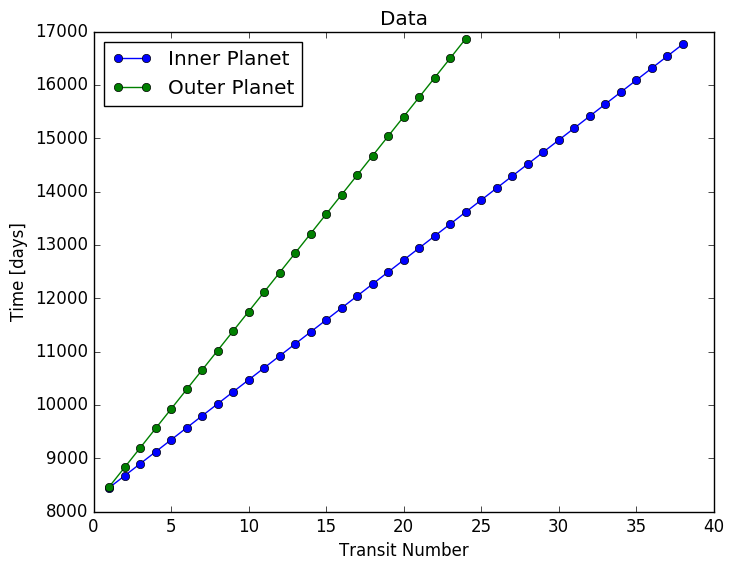

PyObject <matplotlib.legend.Legend object at 0x3253f7790>

In [13]:
times_test1 = times_from_ttvs(obs_ttv1, bestP1, time1[1])
times_test2 = times_from_ttvs(obs_ttv2, bestP2, time2[1])

plot(linspace(1,length(time1), length(time1)), time1, "o-", label="Inner Planet")
plot(linspace(1,length(time2), length(time2)), time2, "o-", label="Outer Planet")
ylabel("Time [days]")
xlabel("Transit Number")
title("Data")
legend(loc=2)

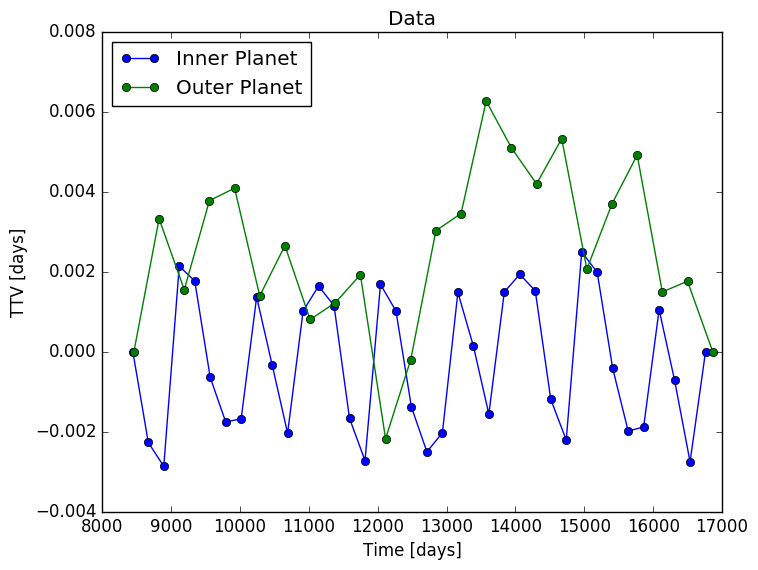

PyObject <matplotlib.legend.Legend object at 0x325425fd0>

In [14]:
obs_ttv1 = ttvs_from_times(time1, bestP1)
obs_ttv2 = ttvs_from_times(time2, bestP2)

plot(time1, obs_ttv1, "o-", label="Inner Planet")
plot(time2, obs_ttv2, "o-", label="Outer Planet")
ylabel("TTV [days]")
xlabel("Time [days]")
title("Data")
legend(loc=2)

# Wrapper for `compute_ttv.jl`

In [15]:
# Load in compute_ttv
include("../compute_ttv.jl")

TTVFaster

In [16]:
# Define some test parameters

#planet1
MpMs1 = 0.001
P1 = mdt1
t01 = 1.0
esw1 = 0.1
ecw1 = 0.1

#planet2
MpMs2 = 0.001
P2 = mdt2
t02 = 1.0
esw2 = 0.1
ecw2 = 0.1

# Construct planet
planet_test = TTVFaster.Planet_plane_hk(MpMs2, P2, t02, esw2, ecw2)

In [197]:
function construct_planets(params::Vector)
    """
    This function takes a vector of parameters and returns a list of 
    planet_plane_hk objects
    """
    
    # NOTE: 5 model parameters per planet
    
    # Check for correct number of params
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params. Must be multiple of 5!")
        return nothing
    else
        N = Int(length(params) / 5)
        # Construct Planet grid
        plist = []
        for i=1:N
            push!(plist, TTVFaster.Planet_plane_hk(params[5*(i-1)+1], 
                                                   params[5*(i-1)+2], 
                                                   params[5*(i-1)+3], 
                                                   params[5*(i-1)+4],
                                                   params[5*(i-1)+5]))
        end 
    end 
    return plist
end

construct_planets (generic function with 1 method)

In [198]:
# Test function
p0 = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];
planets_test = construct_planets(p0)

2-element Array{Any,1}:
 TTVFaster.Planet_plane_hk{Float64}(1.0e-6,224.70076641863517,1.0,0.1,0.1)
 TTVFaster.Planet_plane_hk{Float64}(1.0e-6,365.25630708152175,1.0,0.1,0.1)

In [199]:
function construct_planet_phase_times(tti::Array{Float64,1}, 
                                      Pj::Float64, 
                                      t0j::Float64)
    """
    For a non-transiting planet j, computes fake 'transit times' based on 
    observational duration of a transiting planet i, and planet j's period 
    and epoch
    """
    
    # Duration over which planet i transits were observed:
    obs_duration = tti[end] - tti[1]
    
    # Number of planet j transits over that duration:
    Ntj = Int(round(obs_duration / Pj))
    
    # Transit times of planet j (shifted by t0)
    if Ntj == 1
        ttj = [tti[1] .+ t0j]
    else
        ttj = collect(linspace(0.0,obs_duration, Ntj)) .+ tti[1] .+ t0j
    end 
    
    return ttj
end

construct_planet_phase_times (generic function with 1 method)

In [ ]:
# Test function with something Jupiter-like 
guessP3 = 4332.0
    t03 = 100.0
construct_planet_phase_times(time1, guessP3, t03)

In [200]:
# We're overloadding the crap out of the following function. No good reason for this :)

function deconstruct_data_grid(data::Array{Float64, 2},i::Int64)
    """
    Removes zeros from data grid and returns time grid for planets i
    """
    
    # Number of planets with data
    N =  length(data[1,:])
    
    # Error check
    if i > N
        println("ERROR: Invalid i in deconstruct_data_grid(data, i)")
    end
    
    # Zero mask
    maski = data[:,i] .> 0.0
    
    # Extract arrays from data matrix
    timei = data[maski,i]
    
    return timei
end 

function deconstruct_data_grid(data::Array{Float64, 2}, i::Int64, j::Int64)
    """
    Removes zeros from data grid and returns time grids for planets i & j
    """

    # Extract arrays from data matrix
    timei = deconstruct_data_grid(data, i)
    timej = deconstruct_data_grid(data, j)
    
    return timei, timej
end 

function deconstruct_data_grid(data::Array{Float64, 2}; return_data::Bool=false)
    """
    This function takes a 2d data array and returns a list of data/zeros with unqeual lengths
    """
  
    # Number of planets
    N =  length(data[1,:])
    
    # Mask columns with non-zero first element-- transiting planets!
    transiting = data[1,:] .> 0.0
    
    # Number of planets with transit data
    Nt = sum(transiting)
    
    # Allocate memory for ttv arrays
    ttv_list = []
    for i=1:length(transiting)
        # Only if transiting
        if transiting[i]
            if return_data
                # Get data
                tmp = deconstruct_data_grid(data, i)
            else
                # Set zeros
                len = sum(data[:,i] .> 0)
                tmp = zeros(len)
            end
            # Push to ttv_list
            push!(ttv_list, tmp)
        end
    end    
    
    return ttv_list, transiting
end 

deconstruct_data_grid (generic function with 3 methods)

In [201]:
function two_planet_ttv_model(time1::Array{Float64, 1},
                              time2::Array{Float64, 1}, 
                              planet1::TTVFaster.Planet_plane_hk{Float64}, 
                              planet2::TTVFaster.Planet_plane_hk{Float64};
                              jmax::Int64=5)
    """
    This model computes mutual TTVs between planet 1 & planet 2
    """
    
    # Allocate memory for ttv's
    ttv1 = zeros(length(time1));
    ttv2 = zeros(length(time2));
    
    # Call compute_ttv! Note: modifies ttv1, ttv2 in place
    TTVFaster.compute_ttv!(jmax, planet1, planet2, time1, time2, ttv1, ttv2)

    return ttv1, ttv2
end 

two_planet_ttv_model (generic function with 1 method)

In [202]:
function N_planet_ttv_model(data::Array{Float64,2}, params::Vector)
    """
    This model computes the TTV signal of all specified planets, 
    due to all other planets. Returns a list of transit times arrays 
    for all transiting planets.
    """
    
    # Number of planets
    N =  length(data[1,:])
    
    # Create list for ttv model data, initialized with zeros.
    # Also returns boolean list for "if transiting?"
    ttv_list, transiting = deconstruct_data_grid(data; return_data=false)
    
    # Construct planet grid from params
    planets = construct_planets(params)
    
    # Loop over N(N-1) planets (no double counting), 
    # sum planet ttv contributions due to all other planets
    for i=1:(N-1)        
        for j=(i+1):N
            
            # Deconstruct data grid
            ti, tj = deconstruct_data_grid(data, i, j)
            
            # If either planet i or j is not transiting, 
            # construct 'transit phase' grid from period, t0
            if ~ transiting[i]
                ti = construct_planet_phase_times(tj, planets[i].period, planets[i].trans0)
            end 
            if ~ transiting[j]
                tj = construct_planet_phase_times(ti, planets[j].period, planets[j].trans0)
            end 
            
            # Call two-planet ttv
            ttvi, ttvj = two_planet_ttv_model(ti, tj, planets[i], planets[j])
            
            # Sum ttvs, if transiting
            if transiting[i]
                ttv_list[i] = ttv_list[i] .+ ttvi
            end
            if transiting[j]
                ttv_list[j] = ttv_list[j] .+ ttvj    
            end 
            
        end
    end 
    
    # Convert TTVs to transit times for data-model comparison
    times_list = []
    # For each planet,
    for i=1:N
        # If transiting,
        if transiting[i]
            # Convert TTVs to transit times
            tmp = times_from_ttvs(ttv_list[i], planets[i].period, data[1,i])
            # Push to times list
            push!(times_list, tmp)
        end 
    end 
    
    # Return list of transit times for all transiting planets
    return times_list
end 

N_planet_ttv_model (generic function with 1 method)

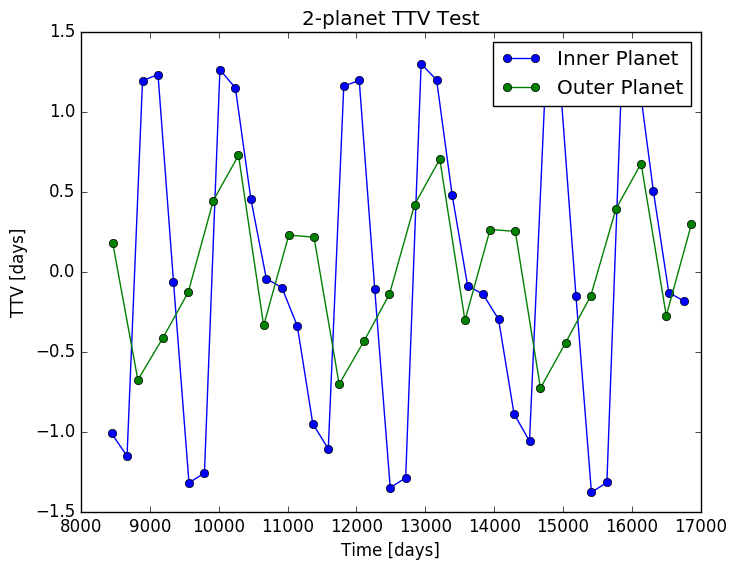

PyObject <matplotlib.legend.Legend object at 0x3253f7950>

In [23]:
# Test two planet ttv model
ttv1, ttv2 = two_planet_ttv_model(time1, time2, planets_test[1], planets_test[2]);
plot(time1, ttv1, "o-", label="Inner Planet")
plot(time2, ttv2, "o-", label="Outer Planet")
title("2-planet TTV Test")
xlabel("Time [days]")
ylabel("TTV [days]")
legend(loc=1)

In [203]:
function construct_data_grid(t1::Array{Float64, 1}, t2::Array{Float64, 1}; N::Int64=2)
    """
    This function takes two arrays of transit times and concatenates them into a 2d 
    rectangular matrix with zeros padding the added elements where no transits exist. 
    N specifies the number of planets.  If N>2, this function will return extra columns 
    of zeros for non-transiting planets (this functionality can probably be removed). 
    """
    
    # Determine which array is longer (aka inner planet)
    if length(t1) > length(t2)
        n1 = length(t1)
        n2 = length(t2)
        x = t1
        y = t2
    else
        n1 = length(t2)
        n2 = length(t1)
        x = t2
        y = t1
    end
    
    # Create new array
    dat = zeros(n1)
    
    # Populate y-grid
    for i=1:n2
        dat[i] = y[i]
    end
    
    # Preserve order
    if length(t1) > length(t2)
        data = [x dat]
    else
        data = [dat x]
    end
    
    # Add additional outer planets
    k = 2
    while k < N
        data = [data zeros(n1)]
        k += 1
    end
    
    return data
end

construct_data_grid (generic function with 2 methods)

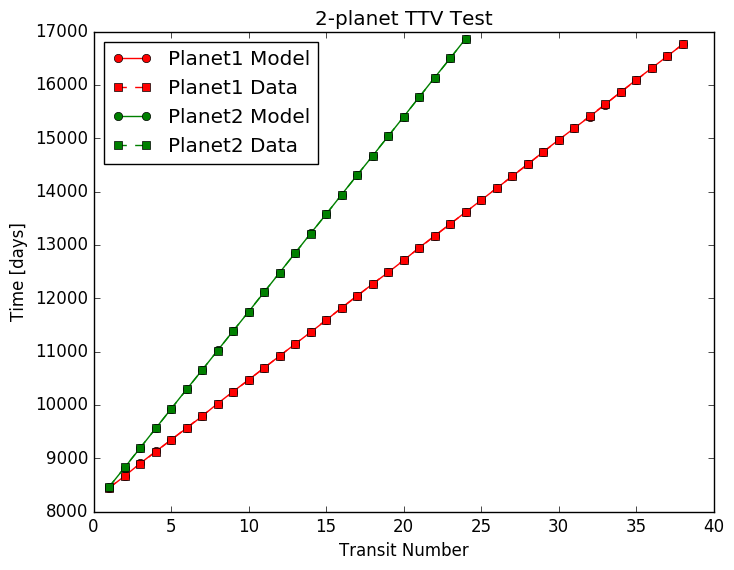

PyObject <matplotlib.text.Text object at 0x32dc7af50>

In [207]:
# Test N planet ttv model

#planet1
MpMs1 = 0.005
P1 = mdt1
t01 = 1.0
esw1 = 0.1
ecw1 = 0.1

#planet2
MpMs2 = 0.005
P2 = mdt2
t02 = 1.0
esw2 = 0.1
ecw2 = 0.1

p0 = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];

data = construct_data_grid(time1, time2, N=2);

times_list = N_planet_ttv_model(data, p0);

# Plot Model & Data
plot(linspace(1,length(time1), length(time1)), times_list[1], "o-", c="r", label="Planet1 Model")
plot(linspace(1,length(time1), length(time1)), time1, "s--", c="r", label="Planet1 Data")
plot(linspace(1,length(time2), length(time2)), times_list[2], "o-", c="g", label="Planet2 Model")
plot(linspace(1,length(time2), length(time2)), time2, "s--", c="g", label="Planet2 Data")
ylabel("Time [days]")
xlabel("Transit Number")
legend(loc=2)
title("2-planet TTV Test")

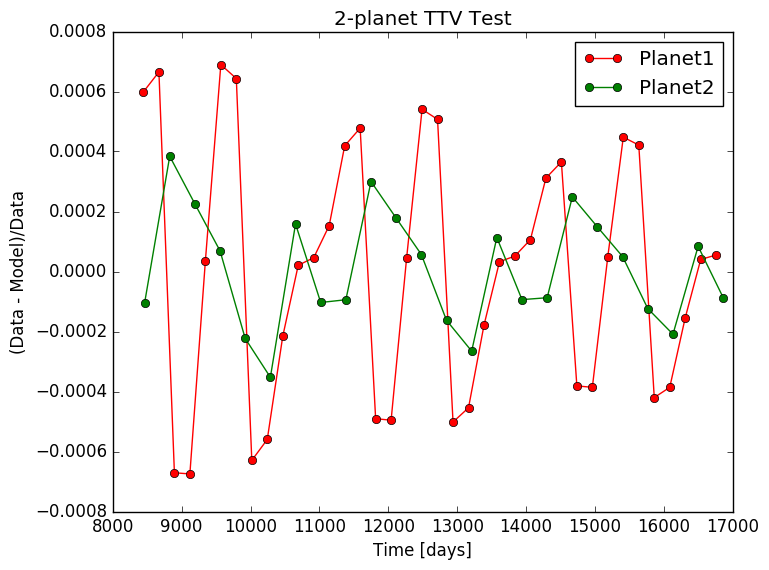

PyObject <matplotlib.text.Text object at 0x32dd8ecd0>

In [208]:
# Test N planet ttv model
p0 = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];
times_list = N_planet_ttv_model(data, p0);
# Plot Model & Data
plot(time1, (time1 .- times_list[1])./time1, "o-", c="r", label="Planet1")
plot(time2, (time2 .- times_list[2])./time2, "o-", c="g", label="Planet2")
ylabel("(Data - Model)/Data")
xlabel("Time [days]")
legend(loc=0)
title("2-planet TTV Test")

**The residuals show a periodic signal, which means our guessed parameters do not accurately fit the TTV signals. No surprise there. We must fit!**

# Fitting with `aimee` (our Affine Invariant MCMC package)

-----

In [31]:
include("aimee.jl")

est_burnin (generic function with 1 method)

In [209]:
function within_five_parameter_ttv_bounds(params::Vector)
    """
    This function contains hard bounds for TTV fitting
    
    params = [MpMs, P, t0, esw, ecw]
    """
    
    global data
    
    # 0 < Masses < 10*Mj
    if (params[1] < 0.0) || (params[1] > 0.01)
        return false
    end
    # 0 < Periods < total observation duration
    if (params[2] < 0.0) || (params[2] > (data[end,1] - data[1,1]))
        return false
    end
    # 0 < t0 < current period
    if (params[3] < 0.0) || (params[3] > params[2])
        return false
    end
    # -1 < esin(w) < 1
    if (params[4] < -1.0) || (params[4] > 1.0)
        return false
    end
    # -1 < ecos(w) < 1
    if (params[5] < -1.0) || (params[5] > 1.0)
        return false
    end
    
    return true 
end

within_five_parameter_ttv_bounds (generic function with 1 method)

In [210]:
function within_hard_prior_bounds(params::Vector)
    """
    Function to impose priors (if ever needed)
    """
    return true
end 

within_hard_prior_bounds (generic function with 1 method)

In [211]:
function lnlike(data::Array{Float64,2},model::Function,params::Vector)
    """
    Log-likelihood function for fitting TTV data. 
    
    Parameters
    ----------
    data : 2D Array
        Transit times for each planet
    model : Function
        TTV model used to fit data
    params : Vector
        State vector of free parameters
        e.g. 2-planets: params = [MpMs1,P1,t01,esw1,ecw1,
                                  MpMs2,P2,t02,esw2,ecw2]
    
    Returns
    -------
    Chi-squared : Float64
        Log of probability that the data can be explained by the model 
    """
    
    # Are there 5 parameters for each planet?
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params: Must be multiple of 5!")
        return Inf
    else
        # Number of planets
        N = Int(length(params) / 5)
    end

    # Get list of transit times for transiting planets
    times_data, transiting = deconstruct_data_grid(data; return_data=true);
    
    # --- Hard Bounds ---
    # Loop over planets
    for i=1:N
        # Check if ith planet params are within hard bounds
        in_bounds = within_five_parameter_ttv_bounds(params[((i-1)*5)+1:(i*5)])
        # If outside bounds, return Inf
        if ~ in_bounds
            return Inf
        end
    end
    
    # --- Priors ---   
    for i=1:N
        if transiting[i]
            # Compute period and std on period
            bestP, stdt = period_from_times(times_data[i])
            # Periods constrained by known mean period form data
            if ( params[5*(i-1)+2] < (bestP - stdt) ) || ( params[5*(i-1)+2] > (bestP + stdt) )
                return Inf
            end
        else
            # Check for user defined hard priors
            in_bounds = within_hard_prior_bounds(params)
            # If outside bounds, return Inf
            if ~ in_bounds
                return Inf
            end
        end 
    end 
    
    # Call model
    times_model = model(data, params);
    
    # Sum the sum-square-diffs for transiting planets
    res = 0.0
    for i=1:length(times_data)
        if transiting[i]
            res += sum((times_model[i] .- times_data[i]).^2)#/sigma^2;   ############## HERE!!!##########
        end
    end 
    
    # data precision: 30 seconds
    sigma = 30. / 60. / 60. / 24.
    
    return res / sigma^2
end

lnlike (generic function with 1 method)

In [212]:
function fit_model_two(nsteps::Int,in_data::Array{Float64,2}; verbose::Bool=true)
    """
    Function to fit TTV data for two planets
    """
    
    # Define global for data
    global data = in_data
    
    # Intial guess for parameters
    #planet1
    MpMs1 = 1e-6
    P1 = mdt1
    t01 = 1.0
    esw1 = 0.1
    ecw1 = 0.1
    #planet2
    MpMs2 = 1e-6
    P2 = mdt2
    t02 = 1.0
    esw2 = 0.1
    ecw2 = 0.1
    
    # Construct state vector
    params = [MpMs1,P1,t01,esw1,ecw1,
              MpMs2,P2,t02,esw2,ecw2];
    
    # Estimated errors for MCMC intialization
    errors = [0.000005, 0.0001, 1.0, 0.1, 0.1, 0.000005, 0.0001, 1.0, 0.1, 0.1];
    
    # Check that the number of parameters is correct
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params: Must be multiple of 5!")
        return nothing
    end 

    # Run and return MCMC results
    return affine_inv_mcmc(nsteps,params,N_planet_ttv_model,errors,verbose=verbose,lnlike=lnlike)
end

fit_model_two (generic function with 1 method)

### Attempt 2-planet fit using MCMC

In [185]:
# Construct data grid
data_in = construct_data_grid(time1, time2, N=2);

# Set number of iterations
N = 10000

# Run MCMC
pb, ll, nw, np = fit_model_two(N, data_in; verbose=false);

In [187]:
# Estimate burn in
iburn = est_burnin(pb, nw, np, N)

1276

In [213]:
function derived_parameters(chains, iburn; names=[], verbose=false)
    """
    Estimates Mean parameters from MCMC chains and burn in index
    """
    np = length(chains[1,1,:])
    nw = length(chains[:,1,1])
    mean_p = []
    std_p = []
    for i=1:np
        meantmp = mean(vec(chains[1:nw,iburn:end,i]))
        stdtmp = std(vec(chains[1:nw,iburn:end,i]))
        push!(mean_p, meantmp);
        push!(std_p, stdtmp);
        if names == []
            tmp = ""
        else
            tmp = names[i]
        end
        if verbose
            print(tmp)
            @printf ": %8.3E +/- %8.1E\n" meantmp stdtmp
        end
    end
    return mean_p
end

derived_parameters (generic function with 1 method)

In [190]:
names = ["MpMs1","P1","t01","esw1","ecw1","MpMs2","P2","t02","esw2","ecw2"];
mean_p2 = derived_parameters(pb, iburn, names=names, verbose=true);

MpMs1: 4.462E-07 +/-  3.6E-08
P1: 2.247E+02 +/-  2.6E-06
t01: 6.254E+00 +/-  4.4E+00
esw1: -9.559E-01 +/-  4.3E-02
ecw1: 9.740E-01 +/-  2.2E-02
MpMs2: 6.778E-07 +/-  3.1E-08
P2: 3.653E+02 +/-  5.2E-06
t02: 6.767E+00 +/-  4.1E+00
esw2: -7.069E-01 +/-  3.2E-02
ecw2: 7.084E-01 +/-  1.7E-02


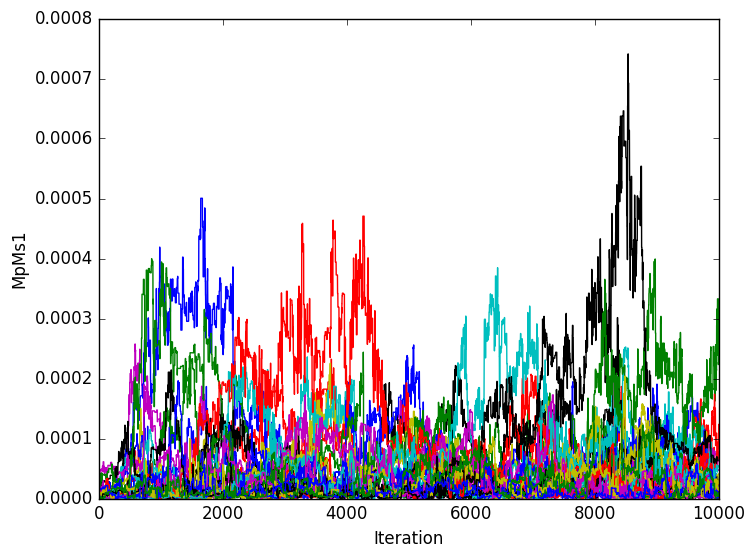

PyObject <matplotlib.text.Text object at 0x328ce6f90>

In [45]:
# Trace plot

# Create iteration grid for plot
x = collect(linspace(1, N, N))
which = 1
for i=1:nw
    plot(x, pb[i,:,which]')
end 
ylabel(names[which])
xlabel("Iteration")

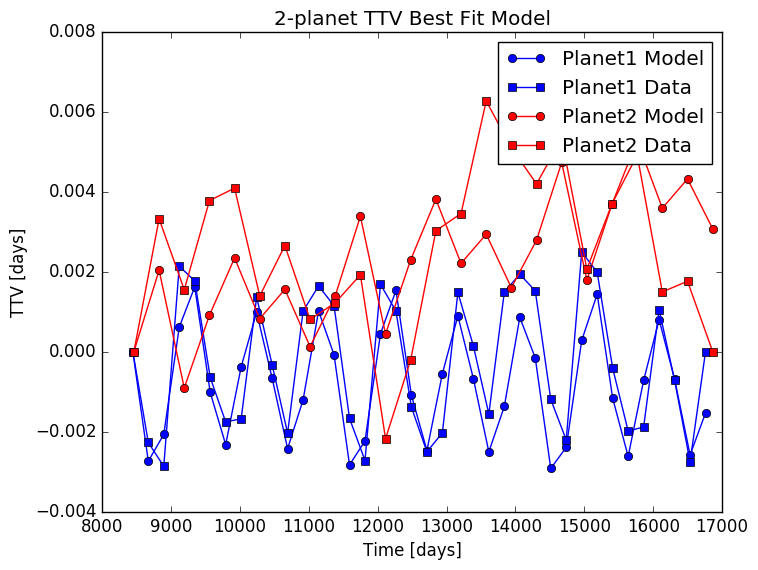

PyObject <matplotlib.legend.Legend object at 0x32a51d250>

In [191]:
# Plot best fitting (mean) model 

# Run model on retrieved parameters
times_list = N_planet_ttv_model(data_in, mean_p2);
    
# Sum the sum-square-diffs for transiting planets
model_ttv1 = ttvs_from_times(times_list[1], bestP1)
model_ttv2 = ttvs_from_times(times_list[2], bestP2)

# Test two planet ttv model
plot(time1, model_ttv1, "o-", c="blue", label="Planet1 Model")
plot(time1, obs_ttv1, "s-", c="blue", label="Planet1 Data")
plot(time2, model_ttv2, "o-", c="red", label="Planet2 Model")
plot(time2, obs_ttv2, "s-", c="red", label="Planet2 Data")
title("2-planet TTV Best Fit Model")
xlabel("Time [days]")
ylabel("TTV [days]")
legend(loc=1)

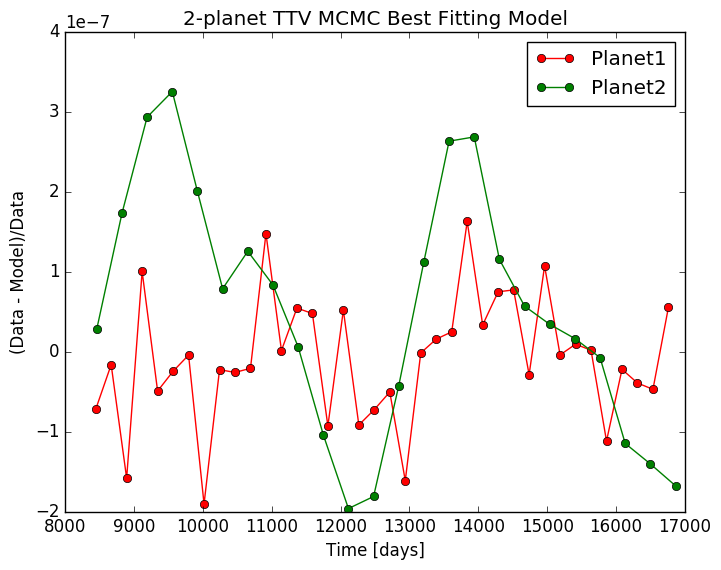

PyObject <matplotlib.text.Text object at 0x32ded4e10>

In [214]:
# Test N planet ttv model
times_list = N_planet_ttv_model(data_in, mean_p2);
# Plot Model & Data
plot(time1, (time1 .- times_list[1])./time1, "o-", c="r", label="Planet1")
plot(time2, (time2 .- times_list[2])./time2, "o-", c="g", label="Planet2")
ylabel("(Data - Model)/Data")
xlabel("Time [days]")
legend(loc=0)
title("2-planet TTV MCMC Best Fitting Model")

**The fit is mediocre at best. The residuals suggest that a third, more massive, planet exists in the system with a period on the order of 4000 days ;)**

## Add 3rd planet
Loop over periods and phases to find best.

In [263]:
function p3_period_loop(periods::Array{Float64, 1})
        
    # Alloc memory for grid search
    p3_loglike = zeros(length(periods))

    # Loop over periods, calc loglike
    for i=1:length(periods)

        # Define phase grid
        phase = collect(linspace(1.0, periods[i], 2))
        phase = [1.0]
        tmpll = zeros(length(phase))

        # Loop over phases
        #for j=1:length(phase)

            #planet3 params
            MpMs3 = 0.001
            P3 = periods[i]
            t03 = phase[1]
            esw3 = 0.01
            ecw3 = -0.01

            p03 = [mean_p2, MpMs3,P3,t03,esw3,ecw3];

            global data = construct_data_grid(time1, time2, N=3);
            
            #aimee
            N = 1000
            iburn = 800
            errors = [0.000005, 0.0001, 1.0, 0.1, 0.1, 
                0.000005, 0.0001, 1.0, 0.1, 0.1, 
                0.000005, 0.0001, 1.0, 0.1, 0.1];
            pb, ll, nw, np = affine_inv_mcmc(N,p03,N_planet_ttv_model,errors,verbose=false,lnlike=lnlike)
            meantmp = derived_parameters(pb, iburn, verbose=false)
            tmpll[1] = optim_lnlike(meantmp)
            #tmpll[j] = lnlike(data_in,N_planet_ttv_model,meantmp)
            
            # Optim
            #global data = data_in
            #optimum = optimize(optim_lnlike, p03, iterations=5000, method=:simulated_annealing)
            #tmpbest = optimum.minimum
            #tmpll[j] = optim_lnlike(tmpbest)


            #tmpll[1] = lnlike(data_in,N_planet_ttv_model,p03)
        #end 

        p3_loglike[i] = minimum(tmpll)
    end 
    return p3_loglike
end 

p3_period_loop (generic function with 2 methods)

In [264]:
# Define period grid
periods = collect(linspace(3000., 5000., 100));

# Calculate loglike
p3_loglike = p3_period_loop(periods);

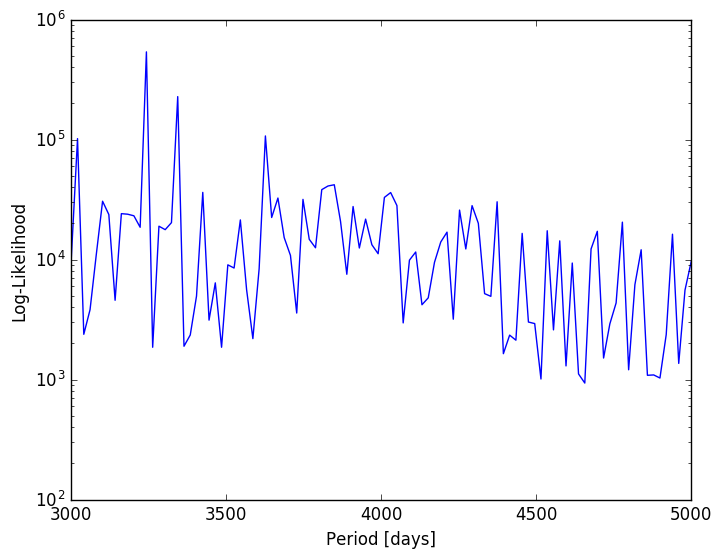

In [279]:
# Test two planet ttv model
plot(periods, p3_loglike)
title("")
xlabel("Period [days]")
ylabel("Log-Likelihood")
yscale("log")

In [267]:
function argmin(x::Array{Float64,1}; MIN::Float64=1.0e-10)
  """
  Returns index of minimum value in x
  """
    for i=1:length(x)
        if abs(x[i] - minimum(x)) < MIN
            return i
        end
    end
end

argmin (generic function with 1 method)

In [268]:
i = argmin(p3_loglike)

83

In [280]:
guessP3 = periods[i]

4656.565656565656

In [107]:
function fit_model_three(nsteps::Int,in_data::Array{Float64,2};
    verbose::Bool=true)
    
    global data = in_data
    
    #planet1
    MpMs1 = 2.4e-6
    P1 = mdt1
    t01 = 1.0
    esw1 = -0.01
    ecw1 = 0.01

    #planet2
    MpMs2 = 3e-6
    P2 = mdt2
    t02 = 1.0
    esw2 = -0.01
    ecw2 = 0.01
    
    #planet3
    MpMs3 = 0.001
    P3 = guessP3
    t03 = 1.0
    esw3 = -0.01
    ecw3 = 0.01
    
    params = [MpMs1,P1,t01,esw1,ecw1,
              MpMs2,P2,t02,esw2,ecw2,
              MpMs3,P3,t03,esw3,ecw3];
    errors = [0.000005, 0.0001, 1.0, 0.1, 0.1, 0.000005, 0.0001, 1.0, 0.1, 0.1, 0.000005, 0.0001, 1.0, 0.1, 0.1];
    
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params: Must be multiple of 5!")
        return nothing
    end 

    return affine_inv_mcmc(nsteps,params,N_planet_ttv_model,errors,verbose=verbose,lnlike=lnlike)
end

fit_model_three (generic function with 1 method)

In [149]:
data_in = construct_data_grid(time1, time2, N=3);

In [154]:
N = 100000
pb, ll, nw, np = fit_model_three(N, data_in; verbose=false);

In [155]:
iburn = est_burnin(pb, nw, np, N)

100000

In [160]:
names = ["MpMs1","P1","t01","esw1","ecw1",
    "MpMs2","P2","t02","esw2","ecw2",
    "MpMs3","P3","t03","esw3","ecw3"];
mean_p3 = derived_parameters(pb, 90000, names=names, verbose=true);

MpMs1: 8.001E-07 +/-  7.5E-08
P1: 2.247E+02 +/-  2.7E-06
t01: 2.506E+01 +/-  2.7E+01
esw1: 2.294E-01 +/-  6.5E-01
ecw1: 1.334E-01 +/-  3.7E-01
MpMs2: 9.757E-07 +/-  5.1E-08
P2: 3.653E+02 +/-  5.4E-06
t02: 8.204E+01 +/-  5.5E+01
esw2: 1.663E-01 +/-  4.7E-01
ecw2: 9.849E-02 +/-  2.7E-01
MpMs3: 1.042E-04 +/-  5.6E-06
P3: 4.413E+03 +/-  3.2E+01
t03: 4.764E+02 +/-  2.6E+02
esw3: 3.279E-01 +/-  9.2E-01
ecw3: 3.281E-01 +/-  9.2E-01


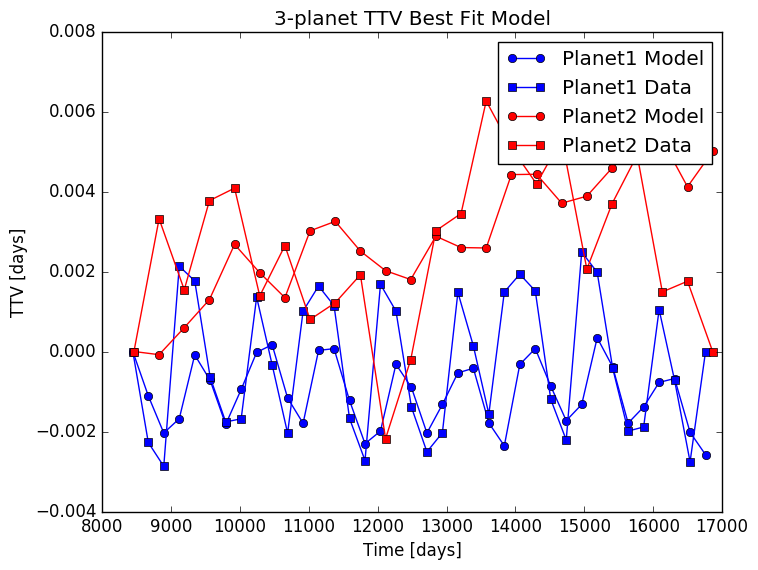

PyObject <matplotlib.legend.Legend object at 0x32b183fd0>

In [161]:
# Run model on retrieved parameters
times_list = N_planet_ttv_model(data_in, mean_p3);
    
# Sum the sum-square-diffs for transiting planets
model_ttv1 = ttvs_from_times(times_list[1], bestP1)
model_ttv2 = ttvs_from_times(times_list[2], bestP2)

# Test two planet ttv model
plot(time1, model_ttv1, "o-", c="blue", label="Planet1 Model")
plot(time1, obs_ttv1, "s-", c="blue", label="Planet1 Data")
plot(time2, model_ttv2, "o-", c="red", label="Planet2 Model")
plot(time2, obs_ttv2, "s-", c="red", label="Planet2 Data")
title("3-planet TTV Best Fit Model")
xlabel("Time [days]")
ylabel("TTV [days]")
legend(loc=1)

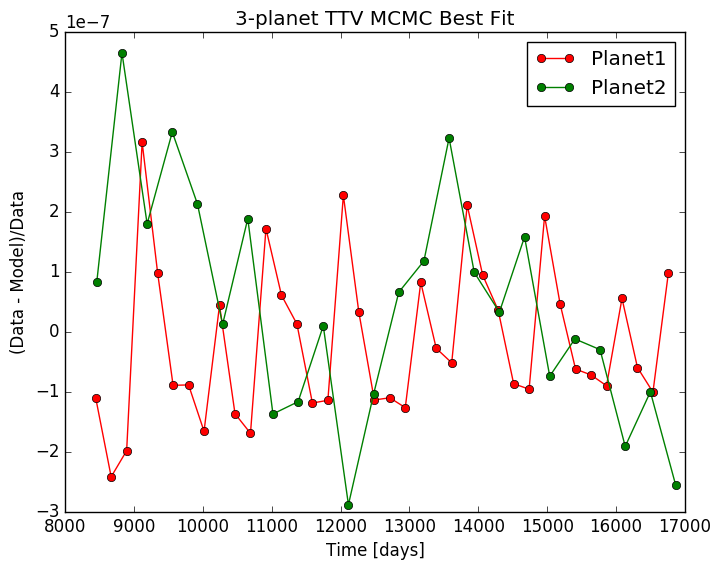

PyObject <matplotlib.text.Text object at 0x32bf5f890>

In [182]:
# Test N planet ttv model
times_list = N_planet_ttv_model(data_in, mean_p3);
# Plot Model & Data
plot(time1, (time1 .- times_list[1])./time1, "o-", c="r", label="Planet1")
plot(time2, (time2 .- times_list[2])./time2, "o-", c="g", label="Planet2")
ylabel("(Data - Model)/Data")
xlabel("Time [days]")
legend(loc=0)
title("3-planet TTV MCMC Best Fit")

## Appendix A: Trying Optim

  0.165341 seconds (273.59 k allocations: 79.286 MB, 12.18% gc time)


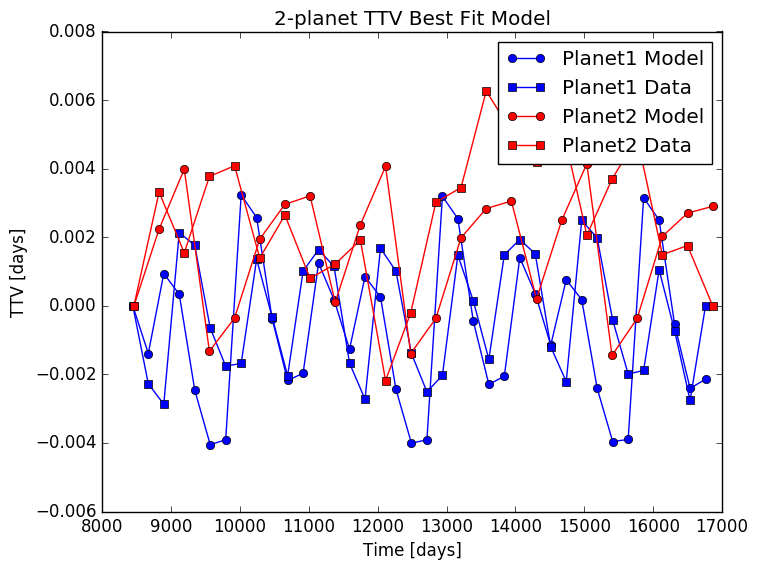

PyObject <matplotlib.legend.Legend object at 0x32e44add0>

In [215]:
# Optim code

function optim_lnlike(params::Vector)
    global data
    return lnlike(data,N_planet_ttv_model,params)
end

function optim_model_two(in_data::Array{Float64,2}, )
    
    global data = in_data
    
    #planet1
    MpMs1 = 2.4e-6
    P1 = mdt1
    t01 = 1.0
    esw1 = -0.1
    ecw1 = 0.1

    #planet2
    MpMs2 = 3e-6
    P2 = mdt2
    t02 = 1.0
    esw2 = -0.1
    ecw2 = 0.1
    
    params = [MpMs1,P1,t01,esw1,ecw1,
              MpMs2,P2,t02,esw2,ecw2];
    #errors = [0.000005, 0.0001, 1.0, 0.1, 0.1, 0.000005, 0.0001, 1.0, 0.1, 0.1];
    
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params: Must be multiple of 5!")
        return nothing
    end 

    optimum = optimize(optim_lnlike, params, iterations=5000, method=:simulated_annealing)

    return optimum.minimum
end

@time optim_best = optim_model_two(data_in)

# Run model on retrieved parameters
times_list = N_planet_ttv_model(data_in, optim_best);
    
# Sum the sum-square-diffs for transiting planets
model_ttv1 = ttvs_from_times(times_list[1], bestP1)
model_ttv2 = ttvs_from_times(times_list[2], bestP2)

# Test two planet ttv model
plot(time1, model_ttv1, "o-", c="blue", label="Planet1 Model")
plot(time1, obs_ttv1, "s-", c="blue", label="Planet1 Data")
plot(time2, model_ttv2, "o-", c="red", label="Planet2 Model")
plot(time2, obs_ttv2, "s-", c="red", label="Planet2 Data")
title("2-planet TTV Best Fit Model")
xlabel("Time [days]")
ylabel("TTV [days]")
legend(loc=1)

In [ ]:
# Optim code 3-planet

function optim_model_three(in_data::Array{Float64,2}, )
    
    global data = in_data
    
    #planet1
    MpMs1 = 2.4e-6
    P1 = mdt1
    t01 = 1.0
    esw1 = -0.01
    ecw1 = 0.01

    #planet2
    MpMs2 = 3e-6
    P2 = mdt2
    t02 = 1.0
    esw2 = -0.01
    ecw2 = 0.01
    
    #planet3
    MpMs3 = 0.001
    P3 = 4333.
    t03 = 1.0
    esw3 = -0.01
    ecw3 = 0.01
    
    params = [MpMs1,P1,t01,esw1,ecw1,
              MpMs2,P2,t02,esw2,ecw2,
              MpMs3,P3,t03,esw3,ecw3];
    #errors = [0.000005, 0.0001, 1.0, 0.1, 0.1, 0.000005, 0.0001, 1.0, 0.1, 0.1];
    
    if mod(length(params), 5) != 0
        println("Incompatible Number of Params: Must be multiple of 5!")
        return nothing
    end 

    optimum = optimize(optim_lnlike, params, iterations=5000, method=:simulated_annealing, autodiff=true)

    return optimum.minimum
end

data_in = construct_data_grid(time1, time2, N=3);

@time optim_best = optim_model_three(data_in)

# Run model on retrieved parameters
times_list = N_planet_ttv_model(data_in, optim_best);
    
# Sum the sum-square-diffs for transiting planets
model_ttv1 = ttvs_from_times(times_list[1], bestP1)
model_ttv2 = ttvs_from_times(times_list[2], bestP2)

# Test two planet ttv model
plot(time1, model_ttv1, "o-", c="blue", label="Planet1 Model")
plot(time1, obs_ttv1, "s-", c="blue", label="Planet1 Data")
plot(time2, model_ttv2, "o-", c="red", label="Planet2 Model")
plot(time2, obs_ttv2, "s-", c="red", label="Planet2 Data")
title("3-planet TTV Best Fit Model")
xlabel("Time [days]")
ylabel("TTV [days]")
legend(loc=1)